In [1]:
import sys
import datetime as dt
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append('../')
from envir import config

/home/cusp/yg833/.conda/envs/birdsVE3.7/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### I. Loading data and processing data

In [2]:
df = pd.read_csv(config.dataFol+'all_cleaned_wsp_sonyc_birds_by_hour.csv')

In [3]:
df.shape

(84894, 28)

In [4]:
df['timestamp_utc'] = pd.to_datetime(df.timestamp_utc)
df['year'] = pd.DatetimeIndex(df.timestamp_utc).year
df['month'] = pd.DatetimeIndex(df.timestamp_utc).month
df['day'] = pd.DatetimeIndex(df.timestamp_utc).day
df['hour'] = pd.DatetimeIndex(df.timestamp_utc).hour

df['localtime'] = pd.to_datetime(df.timestamp_utc).dt.tz_localize('UTC').dt.tz_convert('US/Eastern')
df['localyear'] = pd.DatetimeIndex(df.localtime).year
df['localmonth'] = pd.DatetimeIndex(df.localtime).month
df['localday'] = pd.DatetimeIndex(df.localtime).day
df['localhour'] = pd.DatetimeIndex(df.localtime).hour

#get week of year 
df['weeknumber'] = df['timestamp_utc'].dt.week
#get day of year
df['dayofyear'] = df['timestamp_utc'].dt.dayofyear

In [5]:
df.sonyc_sensor_name.unique()

array(['19 Washington Square North', nan, 'Silver lab', 'Juan Carlos',
       'Shimkin Reading Room', '4 Washington Square North',
       'Kimmel Center'], dtype=object)

<b>Create a new dataframe df_new with localhour in range [4am, 8am] mainly for four sensors</b>
<li>'Silver Lab' sensor: doesn't have YAMNet predication data
<li>'Shimkin Reading Room' sensor: records little bird calls according to YAMNet data

In [6]:
df_new = df[(df.localhour>=4) & (df.localhour <=8) &\
            (df['sonyc_sensor_name'] != 'Shimkin Reading Room') &\
            (df['sonyc_sensor_name'] != 'Silver lab') &\
            (df['sonyc_sensor_name'].isnull() == False) ].copy()

df_new.rename(columns={'avg_mt_#/km':'avg_mt_km','avg_mtr_#/km/h':'avg_mtr_kmh'}, inplace = True)

In [7]:
df_new.sonyc_sensor_name.unique()

array(['19 Washington Square North', 'Juan Carlos',
       '4 Washington Square North', 'Kimmel Center'], dtype=object)

In [8]:
df_new.shape    

(6357, 39)

In [9]:
df_new['pct_positive_predictions'].isnull().sum()  

2700

### II. Time series analysis

<b>Selected features:</b>
pct_positive_predictions (YAMNet), dBAS_lin_mean (SPL), avg_mt_km (Nexrad), temp_celcius (Weather)

<b>Time Range:</b>
Late February to early May for 2017, 2018, 2019, 2020

<b>Sensors:</b>
'19 Washington Square North', 'Juan Carlos', '4 Washington Square North', 'Kimmel Center'

In [14]:
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.plot import plot_plotly
import plotly.offline as py
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() 

#ignore figure.max_open_warning
plt.rcParams.update({'figure.max_open_warning': 0})
#ignore FutureWarning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


#### i. Preprocessing 

In [15]:
features = ['yamnet','spl','nexrad','weather']
features_dict = {'yamnet':'pct_positive_predictions','spl':'dBAS_lin_mean','nexrad':'avg_mt_km','weather':'temp_celcius'}
years = ['2017','2018','2019','2020']

In [16]:
#dynamically create a dataframe for each feature for each year (16 dataframes in total)
for feature in features:
    feature_col = features_dict[feature]
    for year in years:
        #group by month-day-hour
        locals()['df_{0}_{1}'.format(feature, year)] = df_new[(df_new.localyear == int(year))]\
                                    .groupby(['localmonth','localday','localhour']).mean()\
                                    .loc[:, [feature_col]].reset_index()
        
        #format time index to string 'YYYY-MM-DD-HH' 
        date = [0]*len(locals()['df_{0}_{1}'.format(feature, year)]['localmonth'])
        for index, row in locals()['df_{0}_{1}'.format(feature, year)].iterrows():
            date[index] = '-'.join([year,str(int(row[0])),str(int(row[1])),str(int(row[2]))])

        locals()['df_{0}_{1}'.format(feature, year)]['date'] = date
        
        #convert string time to datetime
        locals()['df_{0}_{1}'.format(feature, year)]['date'] = pd.to_datetime(\
                    locals()['df_{0}_{1}'.format(feature, year)]['date'], format='%Y-%m-%d-%I')

        #loc feature and date columns, set date column as index
        locals()['df_{0}_{1}'.format(feature, year)] = locals()['df_{0}_{1}'.format(feature, year)]\
                                    .loc[:,['date',feature_col]]
        locals()['df_{0}_{1}'.format(feature, year)].set_index('date',inplace=True)
        locals()['df_{0}_{1}'.format(feature, year)].reset_index(inplace = True)
        
        #drop NaN
        locals()['df_{0}_{1}'.format(feature, year)].dropna(inplace = True)
        
        print('df_{0}_{1}'.format(feature, year), locals()['df_{0}_{1}'.format(feature, year)].shape)
        

df_yamnet_2017 (333, 2)
df_yamnet_2018 (358, 2)
df_yamnet_2019 (350, 2)
df_yamnet_2020 (355, 2)
df_spl_2017 (460, 2)
df_spl_2018 (460, 2)
df_spl_2019 (460, 2)
df_spl_2020 (455, 2)
df_nexrad_2017 (460, 2)
df_nexrad_2018 (460, 2)
df_nexrad_2019 (460, 2)
df_nexrad_2020 (455, 2)
df_weather_2017 (460, 2)
df_weather_2018 (460, 2)
df_weather_2019 (460, 2)
df_weather_2020 (454, 2)


In [17]:
df_yamnet_2017.head()

,date,pct_positive_predictions
0,2017-03-01 04:00:00,0.033337
1,2017-03-01 05:00:00,0.000000
2,2017-03-01 06:00:00,0.000000
3,2017-03-01 07:00:00,0.008335
4,2017-03-01 08:00:00,0.058335


#### ii. Fit the Prophet model

The Prophet model has the form: 
<li>yhat = trend + seasonality + holidays + regressors (optional) + noise
   
By default Prophet fits additive seasonalities, meaning the effect of the seasonality is added to the trend to get the forecast. 

Advantages of using Prophet:

<li>Accommodates seasonality with multiple periods (weekly, daily)
<li>Prophet is resilient to missing data
<li>Prophet can make forecasts for time series with sub-daily observations

INFO:numexpr.utils:Note: NumExpr detected 64 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Feature: pct_positive_predictions Year: 2017


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Feature: pct_positive_predictions Year: 2018


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Feature: pct_positive_predictions Year: 2019


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Feature: pct_positive_predictions Year: 2020


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Feature: dBAS_lin_mean Year: 2017


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Feature: dBAS_lin_mean Year: 2018


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Feature: dBAS_lin_mean Year: 2019


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Feature: dBAS_lin_mean Year: 2020


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Feature: avg_mt_km Year: 2017


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Feature: avg_mt_km Year: 2018


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Feature: avg_mt_km Year: 2019


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Feature: avg_mt_km Year: 2020


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Feature: temp_celcius Year: 2017


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Feature: temp_celcius Year: 2018


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Feature: temp_celcius Year: 2019
Feature: temp_celcius Year: 2020


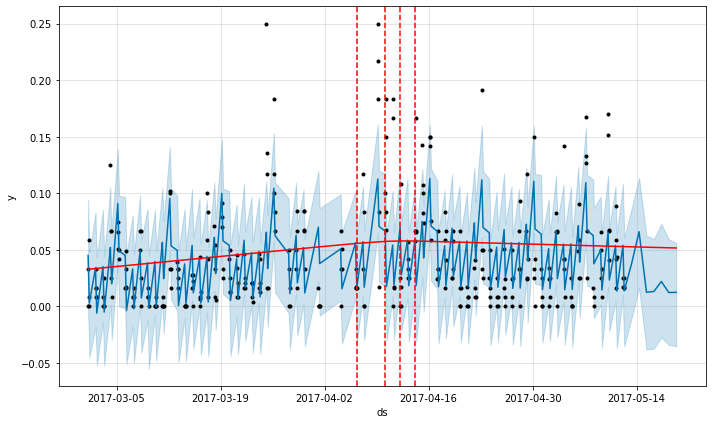

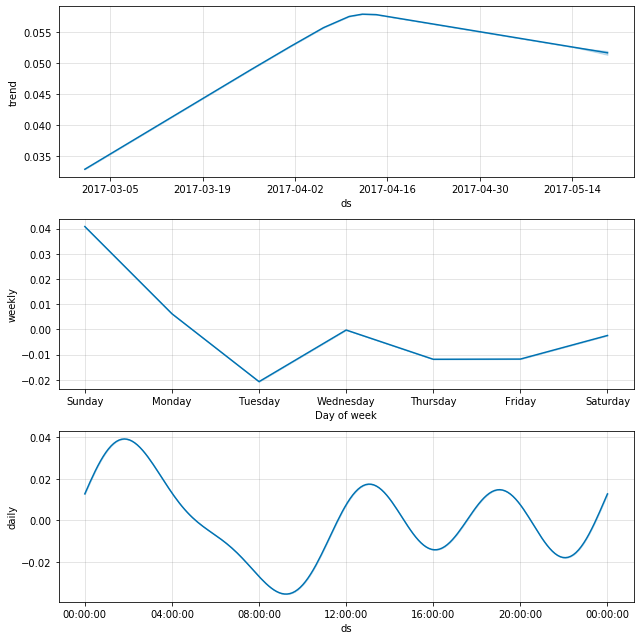

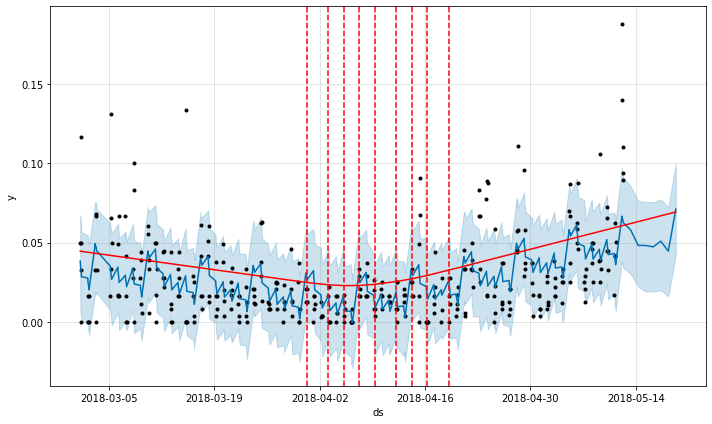

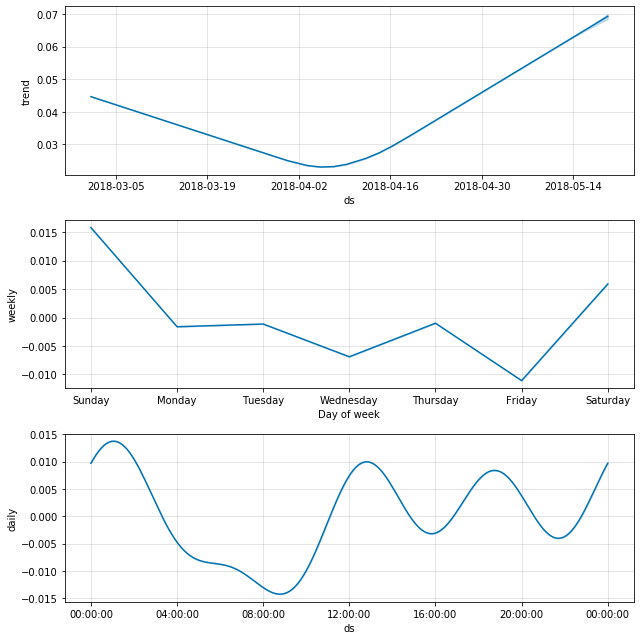

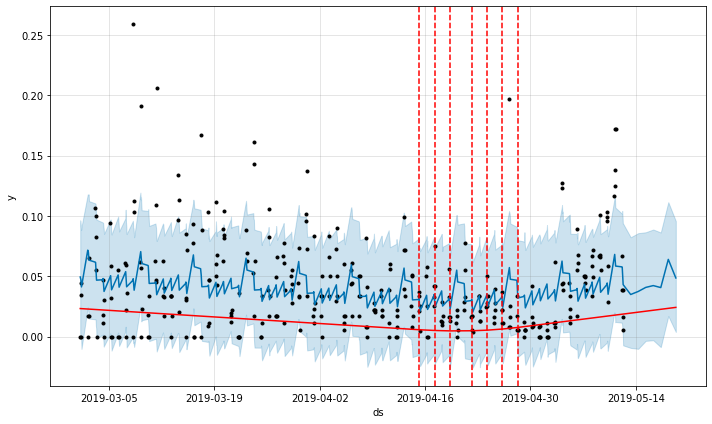

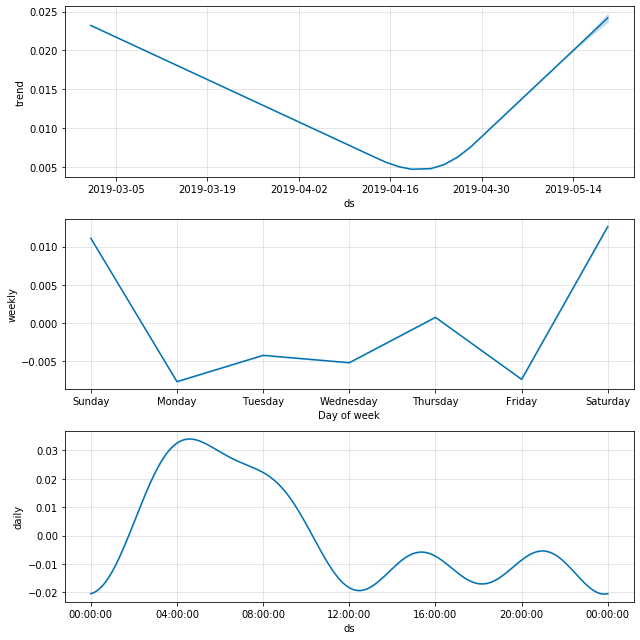

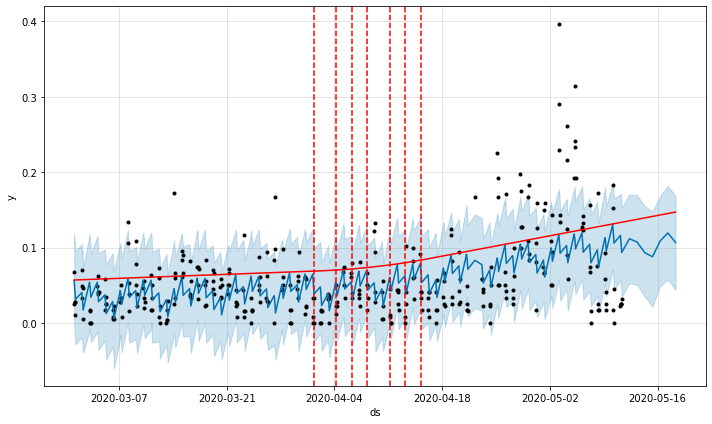

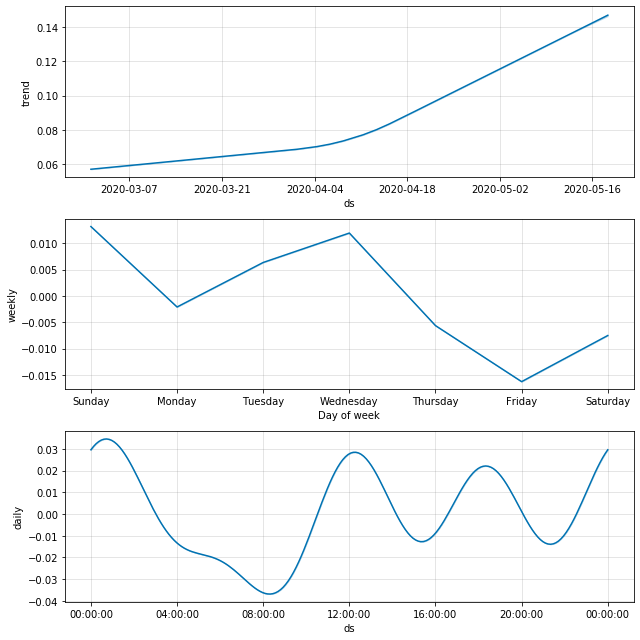

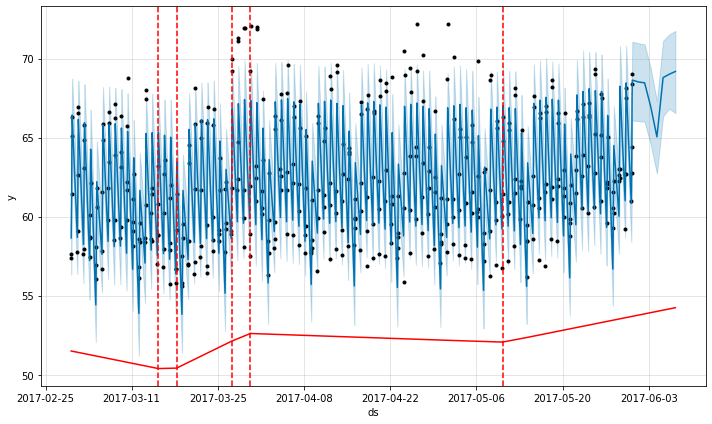

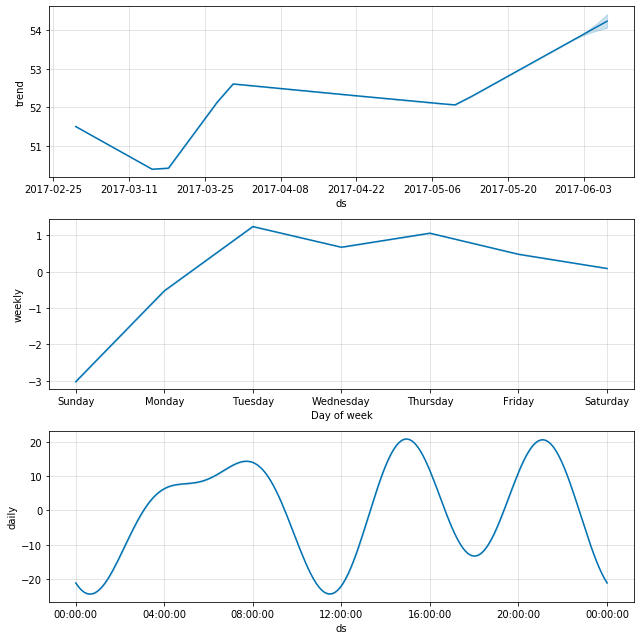

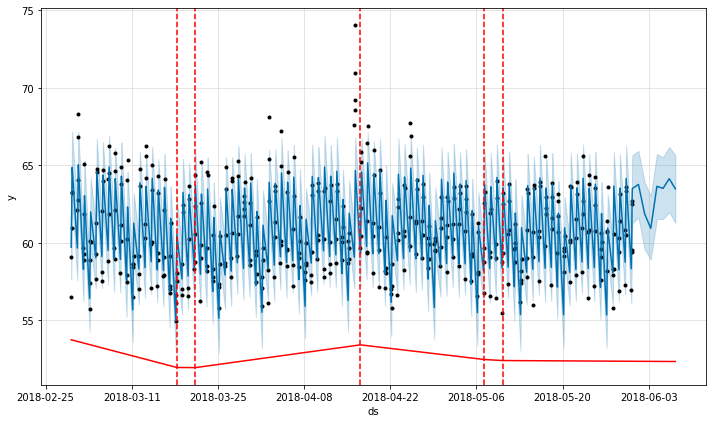

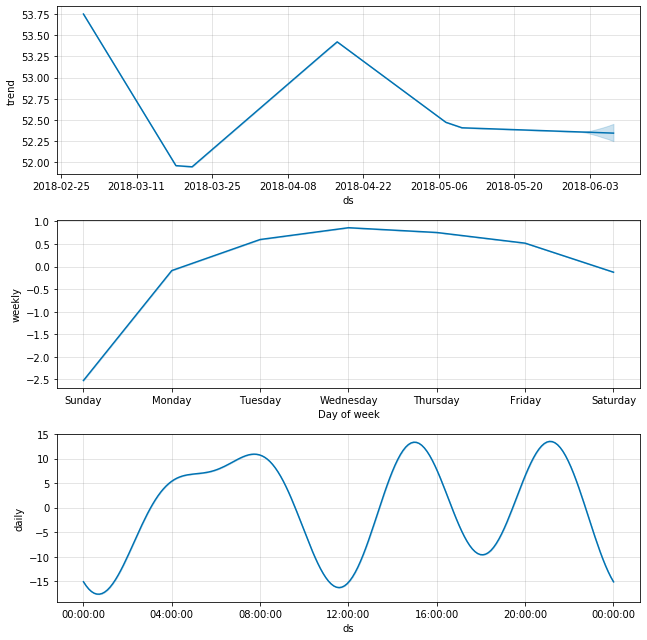

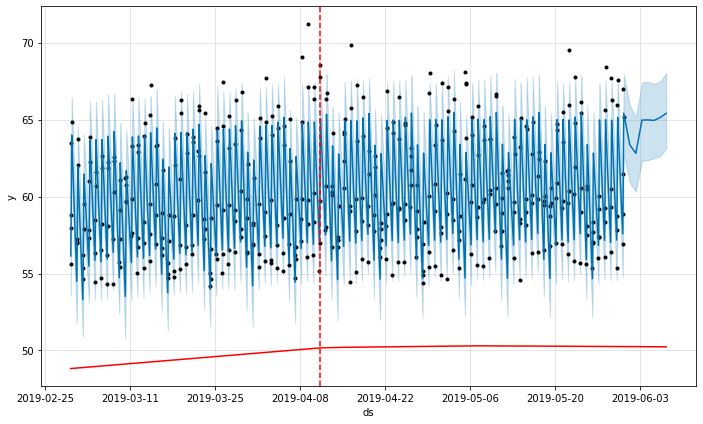

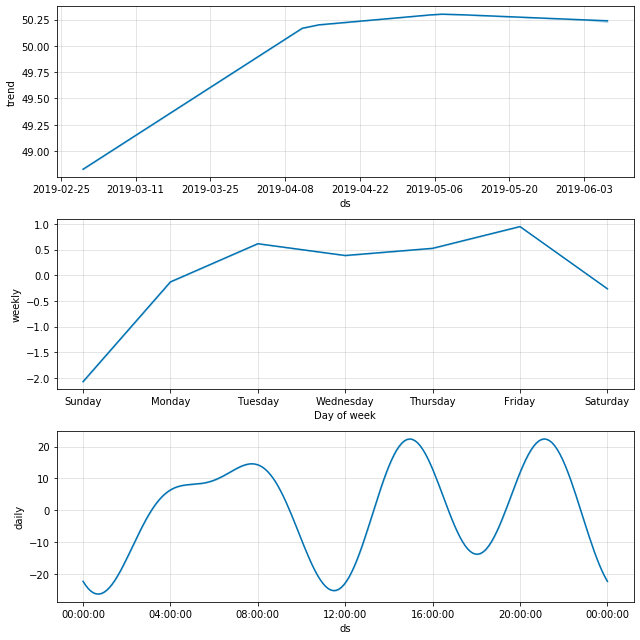

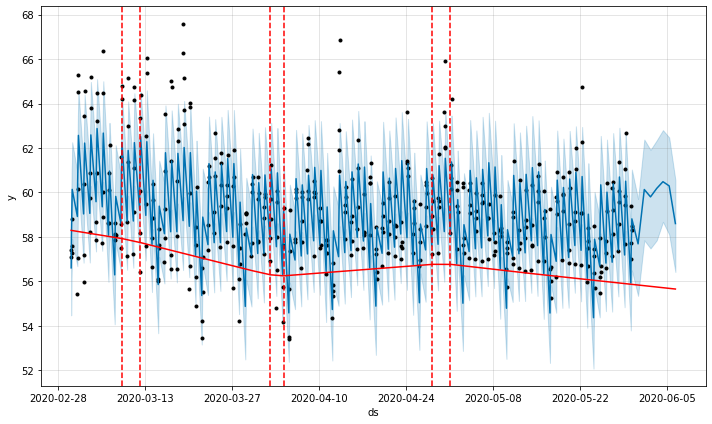

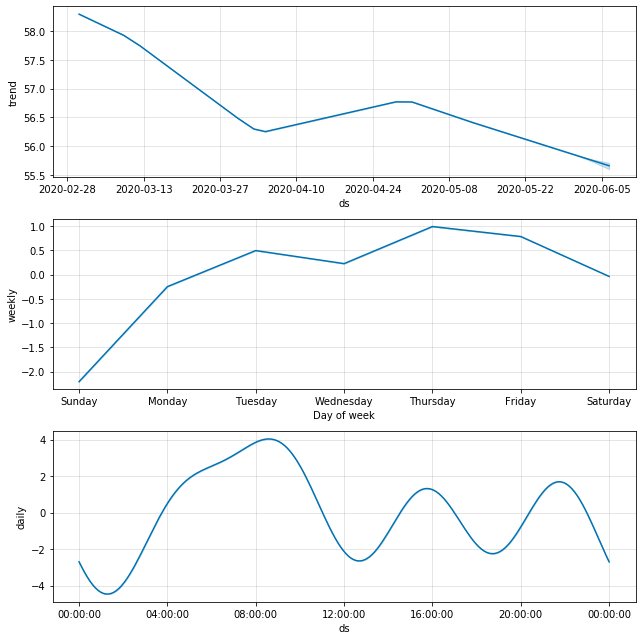

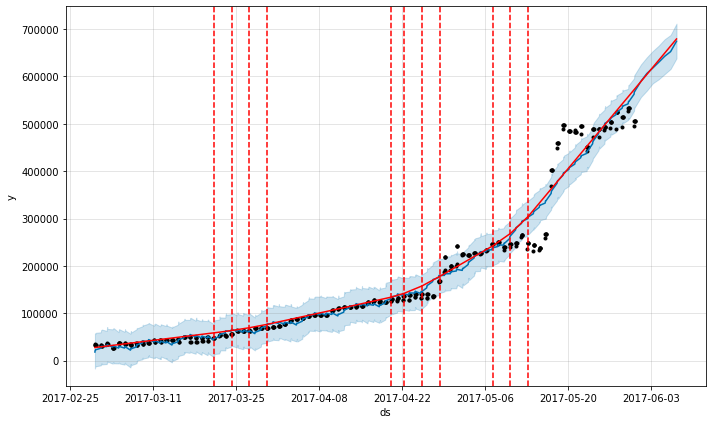

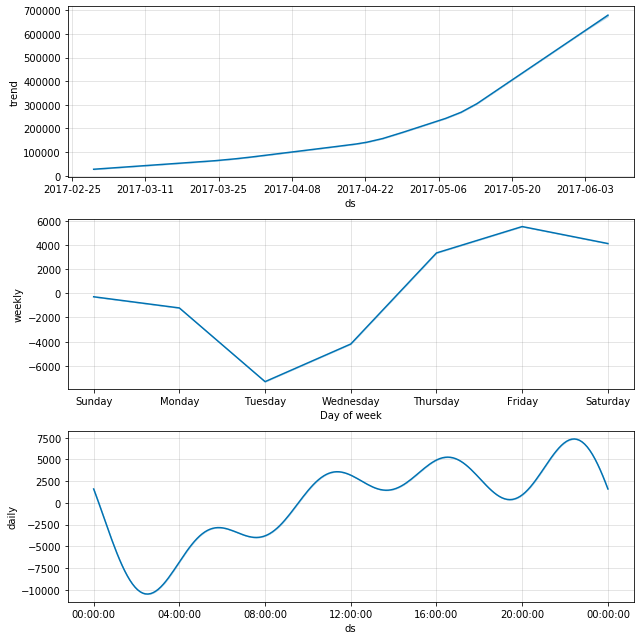

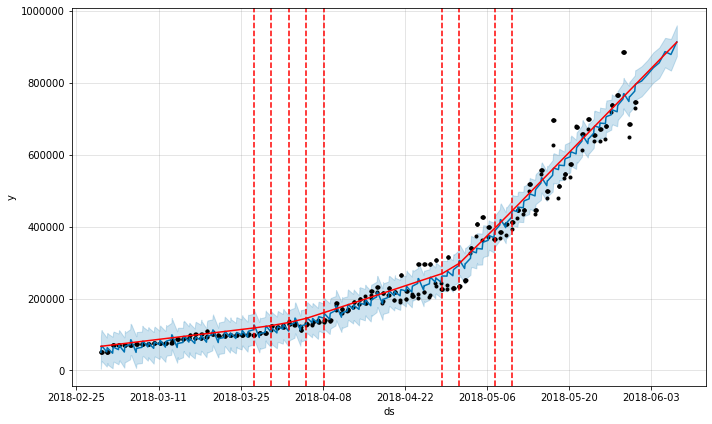

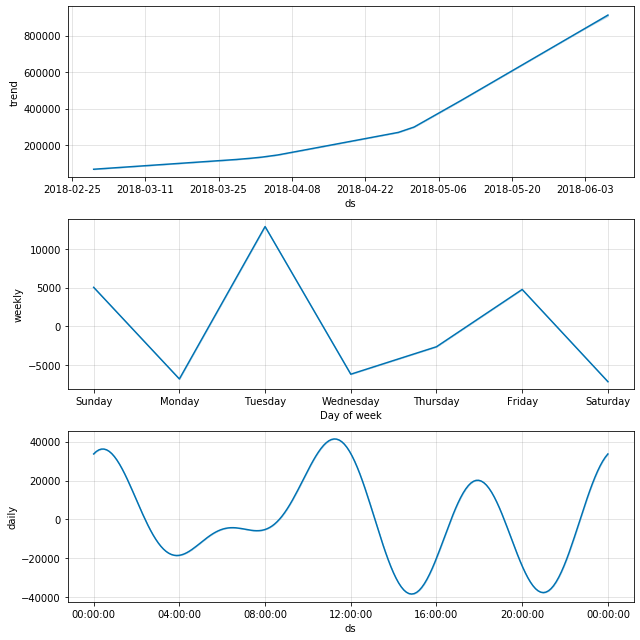

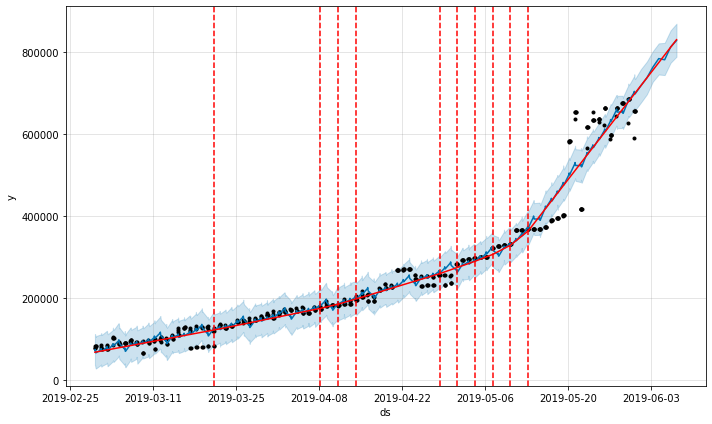

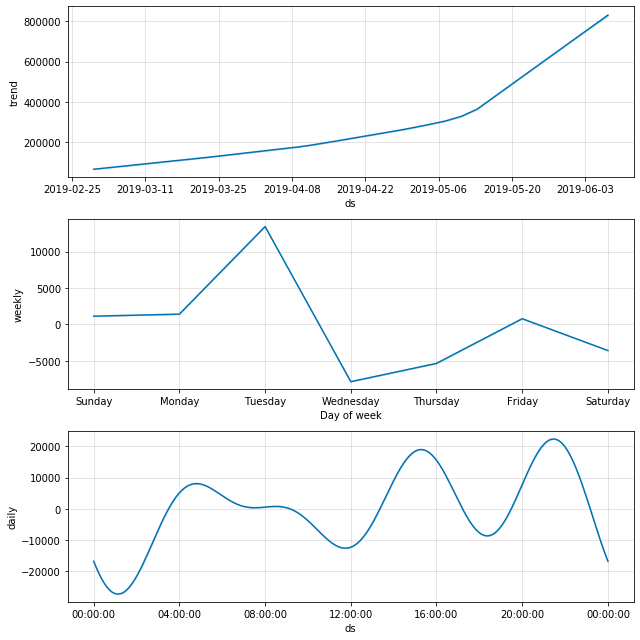

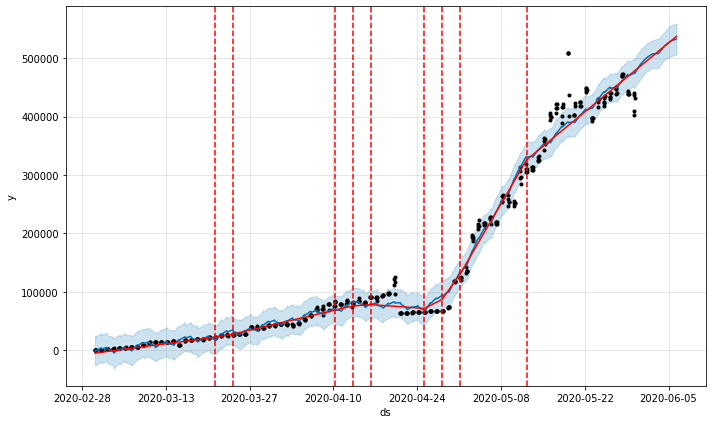

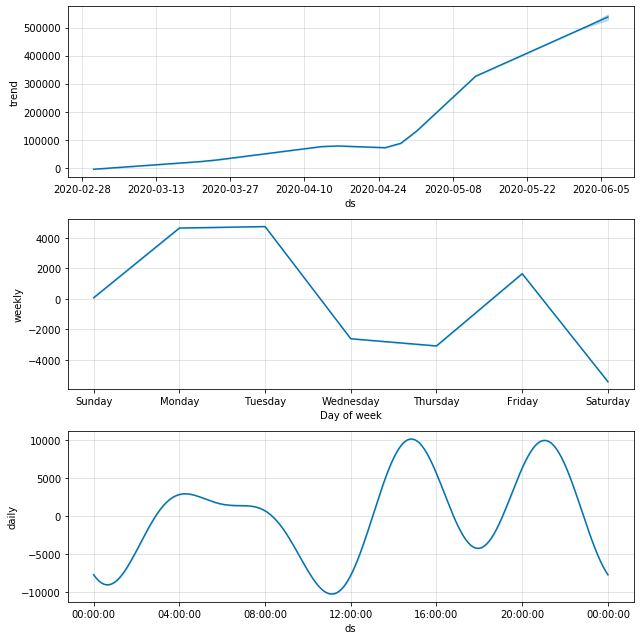

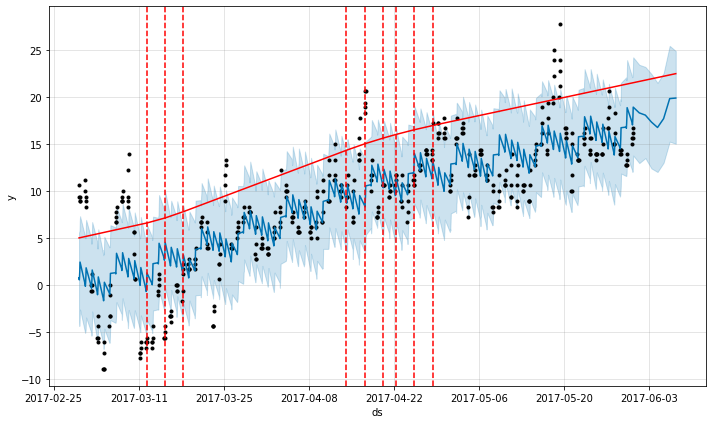

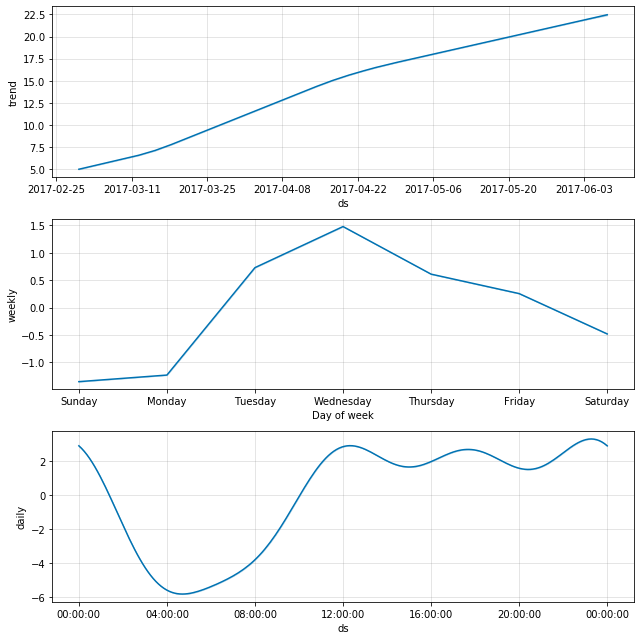

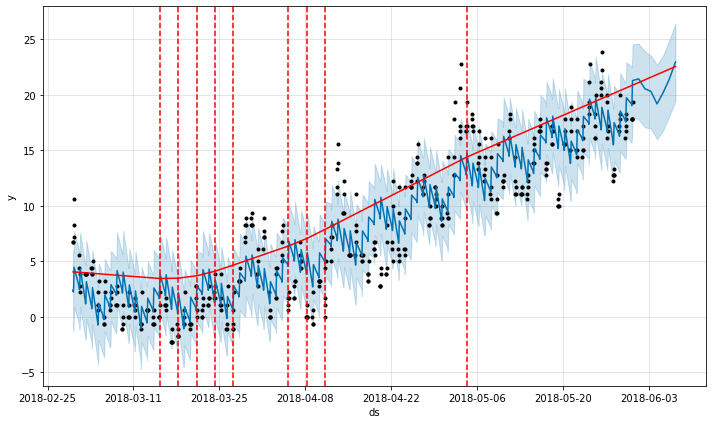

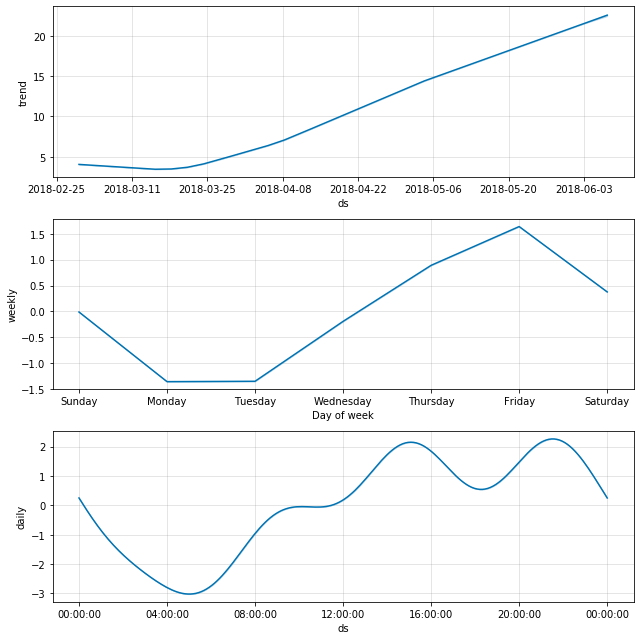

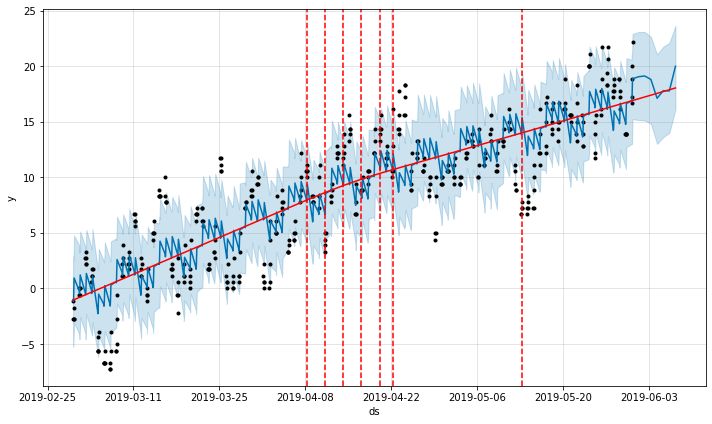

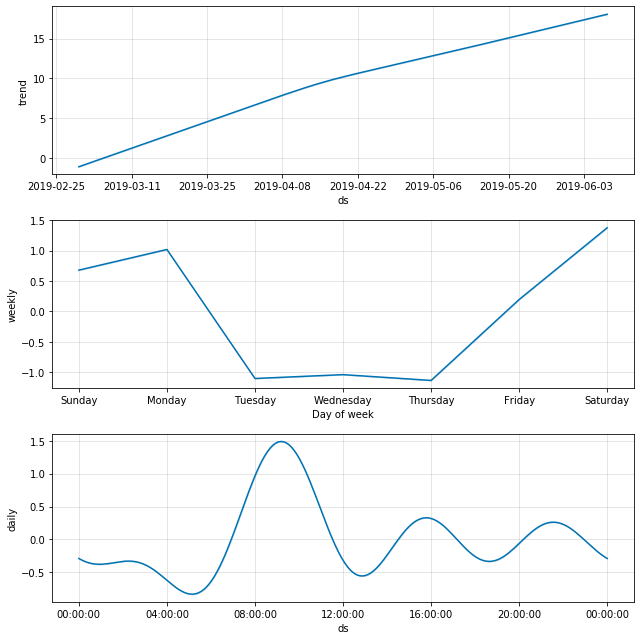

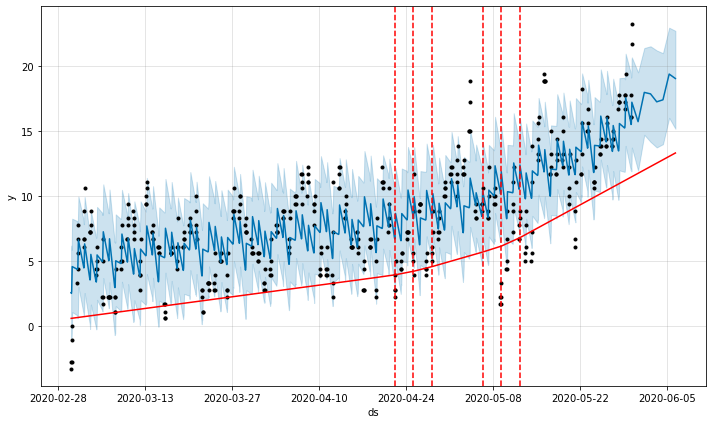

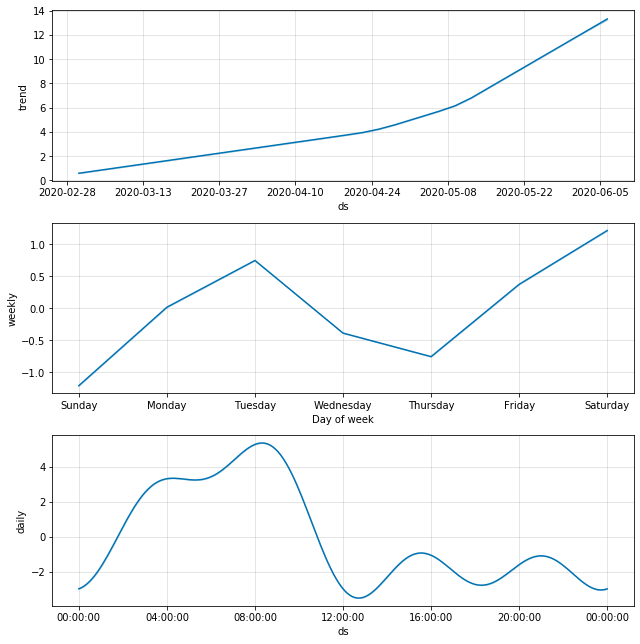

In [18]:
for feature in features:
    feature_col = features_dict[feature]
    for year in years:
        #renme column names as ds and y
        locals()['df_{0}_{1}'.format(feature, year)].rename(columns={'date':'ds', feature_col:'y'}, inplace = True)
        
        #initialize a Prophet constructor
        m = Prophet()
        m.fit(locals()['df_{0}_{1}'.format(feature, year)])
        
        #predicting the trend of furture 7 days
        future = m.make_future_dataframe(periods=7)
        #forecasting
        forecast = m.predict(future)
        
        #plot the time series figure
        fig = m.plot(forecast)
        #adding change points to the first 80% of data (by default)
        a = add_changepoints_to_plot(fig.gca(), m, forecast)
        #plot the trend and seasonalities
        fig2 = m.plot_components(forecast)
        
        #add trend, weekly, and daily seasonalities to each dataframe
        locals()['df_{0}_{1}'.format(feature, year)]['trend_{}'.format(feature_col)] = forecast.trend
        locals()['df_{0}_{1}'.format(feature, year)]['weekly_{}'.format(feature_col)] = forecast.weekly
        locals()['df_{0}_{1}'.format(feature, year)]['daily_{}'.format(feature_col)] = forecast.daily
        
        fig2.savefig('../figures/'+feature_col+'_'+year+'.png')
    
        print('Feature: ' + feature_col + ' Year: ' + year)


In [19]:
df_yamnet_2017.head()

,ds,y,trend_pct_positive_predictions,weekly_pct_positive_predictions,daily_pct_positive_predictions
0,2017-03-01 04:00:00,0.033337,0.032863,-0.001034,0.013221
1,2017-03-01 05:00:00,0.000000,0.032890,-0.001431,0.000827
2,2017-03-01 06:00:00,0.000000,0.032917,-0.001893,-0.007135
3,2017-03-01 07:00:00,0.008335,0.032943,-0.002411,-0.015700
4,2017-03-01 08:00:00,0.058335,0.032970,-0.002978,-0.026973


#### Concatenate trends from each dataframe into one dataframe df_trend

In [20]:
for year in years:
    #make column trend_pct_positive_predictions a dataframe
    locals()['df_trend_{}'.format(year)] = locals()['df_yamnet_{}'.format(year)].loc[:,['ds','trend_pct_positive_predictions']]#.to_frame() 
    
    #merge the trends from the other three features' df to one dataframe
    for feature in features[1:]:
        feature_col = features_dict[feature]
        df_temporary = locals()['df_{0}_{1}'.format(feature, year)]['trend_{}'.format(feature_col)].to_frame()
        locals()['df_trend_{}'.format(year)] = locals()['df_trend_{}'.format(year)].merge(df_temporary,\
                        how = 'outer', left_index = True, right_index = True)

In [21]:
#get the shape of trends dataframe for four years
df_trend_2017.shape,df_trend_2018.shape,df_trend_2019.shape,df_trend_2020.shape

((460, 5), (460, 5), (460, 5), (455, 5))

In [22]:
#concatenate four dataframes into one
df_trend = pd.concat([df_trend_2017,df_trend_2018,df_trend_2019,df_trend_2020])

In [23]:
df_trend.shape

(1835, 5)

In [24]:
df_trend.head()

,ds,trend_pct_positive_predictions,trend_dBAS_lin_mean,trend_avg_mt_km,trend_temp_celcius
0,2017-03-01 04:00:00,0.032863,51.500276,27466.576566,5.000573
1,2017-03-01 05:00:00,0.032890,51.497000,27530.716390,5.006499
2,2017-03-01 06:00:00,0.032917,51.493724,27594.856215,5.012425
3,2017-03-01 07:00:00,0.032943,51.490448,27658.996040,5.018351
4,2017-03-01 08:00:00,0.032970,51.487172,27723.135864,5.024276


#### iii. Regression analysis on trends

<li><b> Analysis on trends

In [25]:
factors = ['trend_dBAS_lin_mean', 'trend_avg_mt_km','trend_temp_celcius']

formula = 'trend_pct_positive_predictions~'+ '+'.join(factors)
formula

'trend_pct_positive_predictions~trend_dBAS_lin_mean+trend_avg_mt_km+trend_temp_celcius'

#### Formula: YAMNet_trend~ SPL_trend + Nexrad_trend + Temperature_trend 

In [26]:
#(WITH INTERCEPT)
lm = smf.ols(formula=formula, data = df_trend).fit()
print(lm.summary())

                                  OLS Regression Results                                  
Dep. Variable:     trend_pct_positive_predictions   R-squared:                       0.662
Model:                                        OLS   Adj. R-squared:                  0.661
Method:                             Least Squares   F-statistic:                     887.4
Date:                            Wed, 22 Jul 2020   Prob (F-statistic):          1.44e-319
Time:                                    22:31:46   Log-Likelihood:                 3624.6
No. Observations:                            1364   AIC:                            -7241.
Df Residuals:                                1360   BIC:                            -7220.
Df Model:                                       3                                         
Covariance Type:                        nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
--

<li><b> Analysis on standardized trends

In [27]:
#standardize: trend_dBAS_lin_mean, trend_avg_mt_km, trend_temp_celcius
for factor in factors: 
    df_trend[factor+'_z']=scaler.fit_transform(np.array(df_trend[factor]).reshape(-1, 1))
    
factors_z = [factor+'_z' for factor in factors]

formula_z = 'trend_pct_positive_predictions~'+ '+'.join(factors_z) 
formula_z

'trend_pct_positive_predictions~trend_dBAS_lin_mean_z+trend_avg_mt_km_z+trend_temp_celcius_z'

#### Formula: YAMNet_trend~ SPL_trend + Nexrad_trend + Temperature_trend (Standardized)

In [28]:
# standardized features (WITH INTERCEPT)
lm = smf.ols(formula=formula_z, data = df_trend).fit()
print(lm.summary())

                                  OLS Regression Results                                  
Dep. Variable:     trend_pct_positive_predictions   R-squared:                       0.662
Model:                                        OLS   Adj. R-squared:                  0.661
Method:                             Least Squares   F-statistic:                     887.4
Date:                            Wed, 22 Jul 2020   Prob (F-statistic):          1.44e-319
Time:                                    22:31:48   Log-Likelihood:                 3624.6
No. Observations:                            1364   AIC:                            -7241.
Df Residuals:                                1360   BIC:                            -7220.
Df Model:                                       3                                         
Covariance Type:                        nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
